In [1]:
%pip install -q langchain langchain_groq langchain_community langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.2/138.2 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.3 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
groq_api_key = userdata.get('groq_api_key')
langsmith=userdata.get('LANGSMITH_API_KEY')

In [3]:
import os
os.environ['LANGCHAIN_API_KEY']=langsmith
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_PROJECT']='LiveLangraph'

In [4]:
from langchain_groq import ChatGroq

In [5]:
llm=ChatGroq(api_key=groq_api_key,model_name='Gemma2-9b-It')

In [25]:
import pandas as pd
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [35]:
class State(TypedDict):
  #message have the type "list". The 'add_messages' function
  #in the annotation defines how this state key should be updated
  messages:Annotated[list,add_messages]
  dataset:pd.DataFrame

graph_builder=StateGraph(State)

In [36]:
data=pd.read_csv('crop_yield_prediction_data_crop_yield.csv')

In [37]:
# Add dataset to initial state
initial_state = {"messages": [], "dataset": data}

In [38]:
def chatbot(state: State):
    # Get the user's latest message
    user_message = state["messages"][-1] if state["messages"] else "Hello!"

    # Generate context for the LLM
    dataset_summary = {
        "columns": state["dataset"].columns.tolist(),
        "row_count": len(state["dataset"]),
        "missing_values": state["dataset"].isnull().sum().to_dict(),
        "summary_statistics": state["dataset"].describe().to_dict(),
    }

    # Prepare the LLM prompt
    prompt = f"""
You are an intelligent assistant for analyzing datasets.
Here is a summary of the dataset:
- Columns: {dataset_summary['columns']}
- Row Count: {dataset_summary['row_count']}
- Missing Values: {dataset_summary['missing_values']}
- Summary Statistics: {dataset_summary['summary_statistics']}

The user has asked the following question: "{user_message}"

Provide a helpful response.
"""

    # Invoke the LLM to generate a response
    response = llm.invoke(prompt)

    # Return the response as part of the updated state
    return {"messages": [response]}


In [39]:
graph_builder.add_node("chatbot", chatbot)

In [40]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

In [41]:
graph = graph_builder.compile()

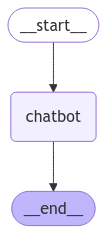

In [42]:
graph

In [44]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({**initial_state, "messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

# Simulate predefined queries
user_queries = [
    "Summarize the dataset",
    "Find the missing values",
    "Show the correlation matrix",
    "What are the columns in the dataset?",
    "How many rows are in the dataset?"
]

# Process each query using streaming
for query in user_queries:
    print(f"User Query: {query}")
    stream_graph_updates(query)
    print("\n")


User Query: Summarize the dataset
Assistant: This dataset contains information about crop yields and the environmental factors that might influence them.  Here's a summary:

**Data Points:**

* **Crop:**  The type of crop being studied (no missing values).
* **Precipitation (mm day-1):** Daily rainfall in millimeters (no missing values).
    *  Average rainfall is around 2486 mm per day.
* **Specific Humidity at 2 Meters (g/kg):**  The amount of water vapor in the air at a height of 2 meters (no missing values).
    *  Averages around 18.2 grams of water per kilogram of air.
* **Relative Humidity at 2 Meters (%):** The percentage of water vapor in the air at 2 meters (no missing values).
    *  Averages around 84.7%.
* **Temperature at 2 Meters (C):**  The air temperature at 2 meters (no missing values).
    *  Averages around 26.2 degrees Celsius.
* **Yield:**  The amount of crop produced (no missing values).
    *  Yields vary significantly, with an average of around 56153 units and 